In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from kde_smooth import kde_smooth
import pynocular as pn

## setup


In [3]:
# raw
a = np.load('/home/dup193/work/double_pulse/notebooks/array_event_57.npy')
a_kde = kde_smooth(a)othing

In [2086]:
# Info about the event from dasha

tau_length = 46.38700257391675
tau_position = (44.1161977511365, 192.84179021584896, -264.71178104775527)
tau_direction = (np.pi - 0.9669433058585615, 5.882517556123219 - np.pi)

In [2077]:
delta_z = 17 #m
delta_t = 10./3 #ns

In [2078]:
z_pos_first_row = -110.40000153
z_pos_last_row =-501.57998657

In [2079]:
x_pos = 11.869999885559082
y_pos = 179.19000244140625

In [2080]:
true_rho = np.sqrt((tau_position[0] - x_pos)**2 + (tau_position[1] - y_pos)**2)

In [2087]:
tau_dx = tau_length * np.sin(tau_direction[0]) * np.cos(tau_direction[1])
tau_dy = tau_length * np.sin(tau_direction[0]) * np.sin(tau_direction[1])
tau_dz = tau_length * np.cos(tau_direction[0])

In [2088]:
tau_position2 = (tau_position[0] + tau_dx, tau_position[1] + tau_dy, tau_position[2] + tau_dz)

In [2089]:
tau_position, tau_position2

((44.1161977511365, 192.84179021584896, -264.71178104775527),
 (8.956670702818691, 207.7346822118397, -291.05117043944244))

In [2090]:
true_rho2 = np.sqrt((tau_position2[0] - x_pos)**2 + (tau_position2[1] - y_pos)**2)

In [2091]:
true_rho, true_rho2

(35.01697568643518, 28.692964819335057)

In [1886]:
g = pn.GridData(t=np.linspace(0,a_kde.shape[0]*delta_t, a_kde.shape[0]), z=np.linspace(z_pos_first_row,z_pos_last_row, a_kde.shape[1])[::-1])

In [2001]:
g['a'] = a_kde

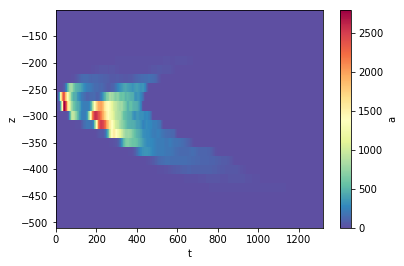

In [2006]:
g.plot('a', cmap='Spectral_r', cbar=True)

## Point like emitter profile, SANTA paper Eq. 22/23

In [2003]:
def calc_t(z, t0=0., z0=0., drho=0., c=0.3*0.75):
    '''calculate the time for a point light emission
    
    Parametrs
    ---------
    
    z : array
        z positions (m)
    t0 : float
        time of emitter (ns)
    z0 : float
        z pos of emitter (m)
    drho : float
        x-y distance (m)
    c : float
        speed of light (ns/m)
    '''
    
    qz = 200 # distance in z
    dc = np.float64(20.)

    dgamma = np.sqrt((z - z0)**2 + drho**2)
    tgamma = dgamma*1/c + t0
    
    return tgamma

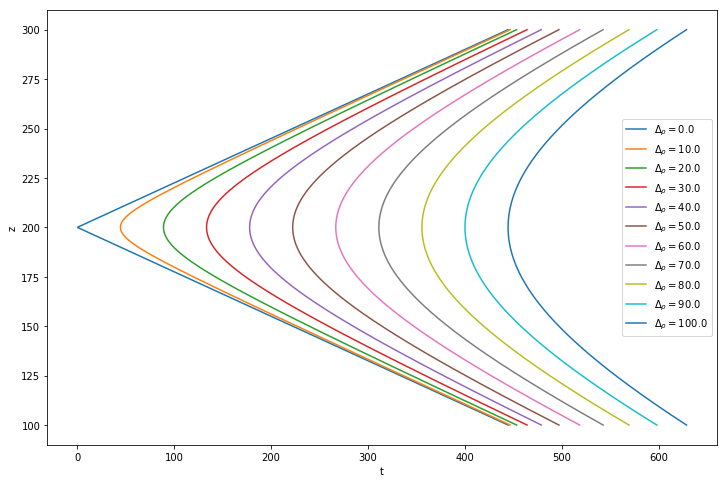

In [2004]:
p = pn.PointData()
N = 1000

p['z'] = np.linspace(100, 300, N)

fig, ax = plt.subplots(1,1, figsize=(12,8))

for drho in np.linspace(0,100,11):
    p['t'] = calc_t(p['z'], z0=200, drho=drho)
    p.plot('t', 'z', label=r'$\Delta_\rho = %s$'%drho, ax=ax)
plt.legend()

In [2007]:
#g['edge'] = ndimage.convolve(g['a'].values, np.array([[3,2,1,0,-1,-2,-3]]).T, mode='constant')
g['edge'] = ndimage.convolve(g['a'].values, np.arange(5,-6,-1)[np.newaxis,:].T, mode='constant')

#g['edge'][g['edge']<0] = 0

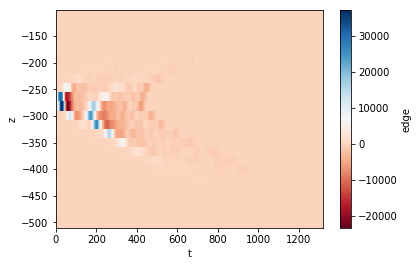

In [2008]:
g.plot('edge', cmap='RdBu', cbar=True)

In [2101]:
# convolved = pn.GridData(t=np.linspace(-200, 200, 31), z=np.linspace(-400, -200, 31))

# c=0.3*0.75
# res = []
# drho = 10.

# for t0, z0 in zip(convolved.flat('t'), convolved.flat('z')):
#     cd = pn.PointData()
#     cd['z'] = np.linspace(-100,100,100) + z0# 
#     cd['t'] = calc_t(cd['z'], t0=t0, z0=z0, drho=drho)
#     cd['weight'] = np.exp((np.abs(cd['t'] - t0)*c + (drho) + np.abs((cd['z'] - z0)))/-100)
#     cd['weight'] /= np.sum(cd['weight'])
#     cd['edge'] = g.lookup(cd)['edge']
#     out = (cd['edge'] * cd['weight']).values
#     r = np.sum(out[np.isfinite(out)])
#     res.append(r)

# convolved['res'] = np.array(res).reshape(convolved.shape)

# correlate with maps

In [2009]:
p = pn.PointData()
N = 1000

t0=50
z0=-333
drho=25

p['z'] = np.linspace(-100, 100, N) + z0
p['t'] = calc_t(p['z'], t0=t0, z0=z0, drho=drho) #+ np.random.randn(len(p))
p['weight'] = np.exp((np.abs(p['t'] - t0)*c + (drho) + np.abs((p['z'] - z0)))/-100)


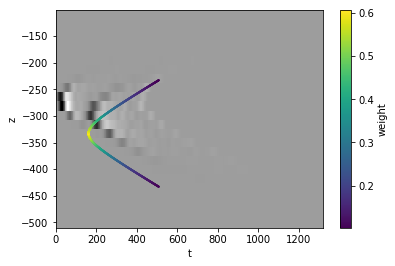

In [2011]:
g.plot('edge',cmap='gray_r')
p.plot_scatter('t', 'z', c='weight', s=1, cbar=True)

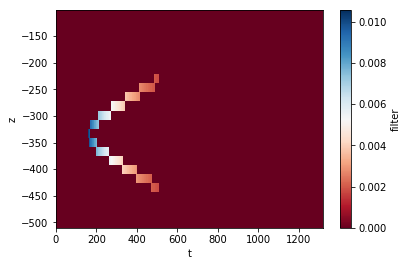

In [2012]:
g['filter'] = p.binwise(g, method='mean')['weight']

g['filter'] /= np.sum(g['filter'])
g.plot('filter', cmap='RdBu', cbar=True)#, vmin=-0.005, vmax=0.005)

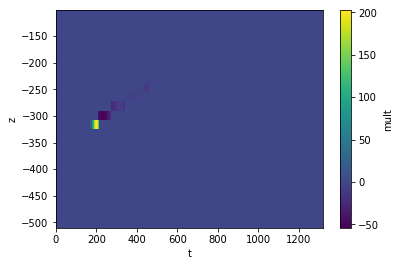

In [2013]:
g['mult'] = g['filter'] * g['edge']
g.plot('mult', cbar=True)

In [2014]:
g['corr'] = ndimage.correlate(g['edge'].values, g['filter'].values, mode='constant')

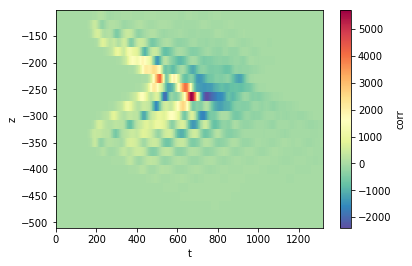

In [2015]:
g.plot('corr', cbar=True, cmap='Spectral_r')

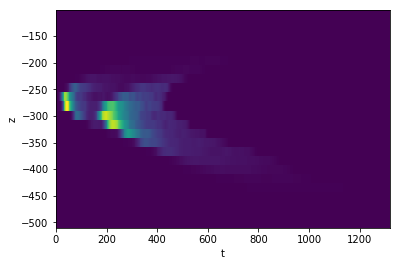

In [2016]:
g.plot('a')

## correlate while shifting points

In [2038]:
out = pn.GridData(t=np.linspace(-200, 500, 61), z=np.linspace(-350, -200, 61), rho=np.linspace(0,150,31))

#print(out['t'].shape)

result = np.zeros(out.shape)

#for t0, z0 in zip(convolved.flat('t'), convolved.flat('z')):

for index in np.ndindex(out.shape):
    #print(index)
    p = pn.PointData()
    N = 500
    t0=out['t'][index]
    z0=out['z'][index]
    drho=out['rho'][index]

    p['z'] = np.linspace(-250, 250, N) + z0
    p['t'] = calc_t(p['z'], t0=t0, z0=z0, drho=drho) #+ np.random.randn(len(p))
    p['weight'] = np.exp((np.abs(p['t'] - t0)*c + (drho) + np.abs((p['z'] - z0)))/-100)
    #p['weight'] = np.float64(1.)/ (np.square(p['t'] - t0) + (drho/c)**2 + ((p['z'] - z0)/c**2) + 10000.)
    p['weight'] /= np.sum(p['weight'])
    
    # move all beginnings to the same location?
    p['t'] += t0 - np.min(p['t'])

    #p['weight'] = np.float64(1.)/ (np.square(p['t'] - np.min(p['t'])) + 1000.)


    g['filter'] = p.binwise(g, method='sum')['weight']
    #g['filter'] /= np.sum(g['filter'])

    result[index] = np.sum(g['edge'] * g['filter'])

    out['result'] = result
#g['corr'] = ndimage.correlate(g['edge'].values, g['filter'].values, mode='constant')



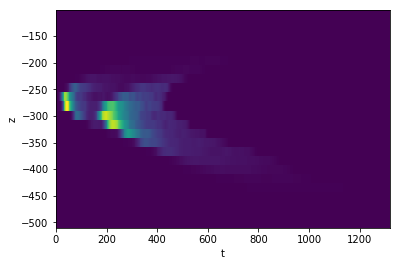

In [2039]:
g.plot('a')

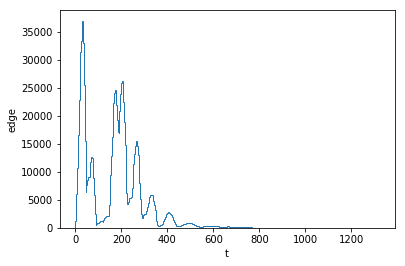

In [2040]:
f(g, axis='z').plot('edge')

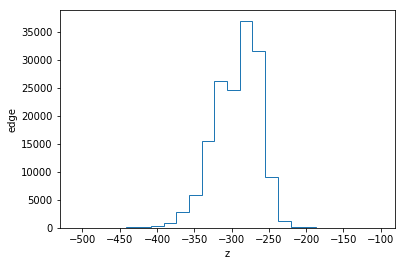

In [2041]:
f(g, axis='t').plot('edge')

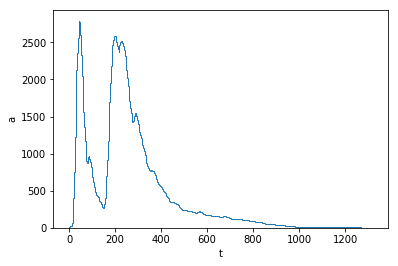

In [2042]:
f(g, axis='z').plot('a')

In [2096]:
f = np.max

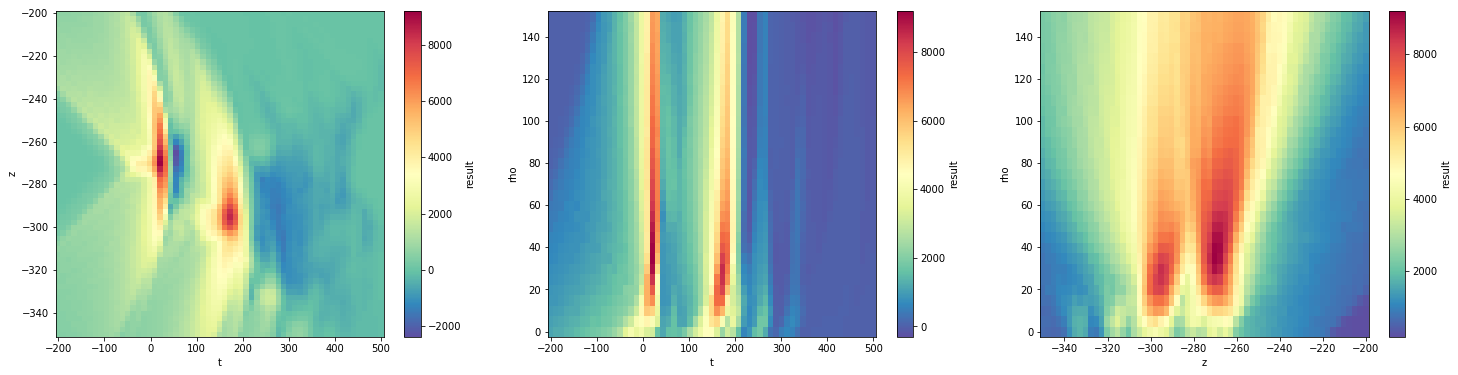

In [2102]:
fig, ax = plt.subplots(1,3,figsize=(25,6))

f(out, axis='rho').plot(cbar=True, cmap='Spectral_r', ax=ax[0])
f(out, axis='z').plot(cbar=True, cmap='Spectral_r', ax=ax[1])
f(out, axis='t').plot(cbar=True, cmap='Spectral_r', ax=ax[2])

In [2098]:
f(out[20:30,:,0:10], axis='z')['result']

rho \ t,33,45,57,68,80,92,1e+02,1.2e+02,1.3e+02,1.4e+02
0,1.6e+03,1.2e+03,1.6e+03,1.6e+03,1.5e+03,1.9e+03,2.5e+03,3.2e+03,3.8e+03,4.4e+03
5,3.3e+03,1.1e+03,1.2e+03,1.6e+03,1.1e+03,1.1e+03,1.5e+03,2.4e+03,3.4e+03,4.3e+03
10,3.7e+03,9.8e+02,1.1e+03,1.5e+03,1.1e+03,1.1e+03,1.4e+03,1.8e+03,2.7e+03,4.1e+03
15,3.9e+03,8.8e+02,9.2e+02,1.3e+03,1.1e+03,1.2e+03,1.4e+03,1.7e+03,2.3e+03,3.3e+03
20,4.2e+03,8.7e+02,9.4e+02,1.2e+03,1.1e+03,1.3e+03,1.4e+03,1.8e+03,2.3e+03,3.2e+03
25,4.6e+03,8.8e+02,9.7e+02,1.1e+03,1.2e+03,1.4e+03,1.5e+03,1.8e+03,2.3e+03,3.3e+03
30,5.4e+03,8.9e+02,9.8e+02,1.1e+03,1.2e+03,1.3e+03,1.6e+03,1.9e+03,2.4e+03,3.3e+03
35,6.1e+03,9.2e+02,1e+03,1.1e+03,1.3e+03,1.4e+03,1.6e+03,2e+03,2.4e+03,3.3e+03
40,6.5e+03,9.2e+02,1e+03,1.1e+03,1.3e+03,1.4e+03,1.7e+03,2e+03,2.5e+03,3.3e+03
45,6.7e+03,9.7e+02,1.1e+03,1.2e+03,1.3e+03,1.5e+03,1.8e+03,2e+03,2.5e+03,3.3e+03


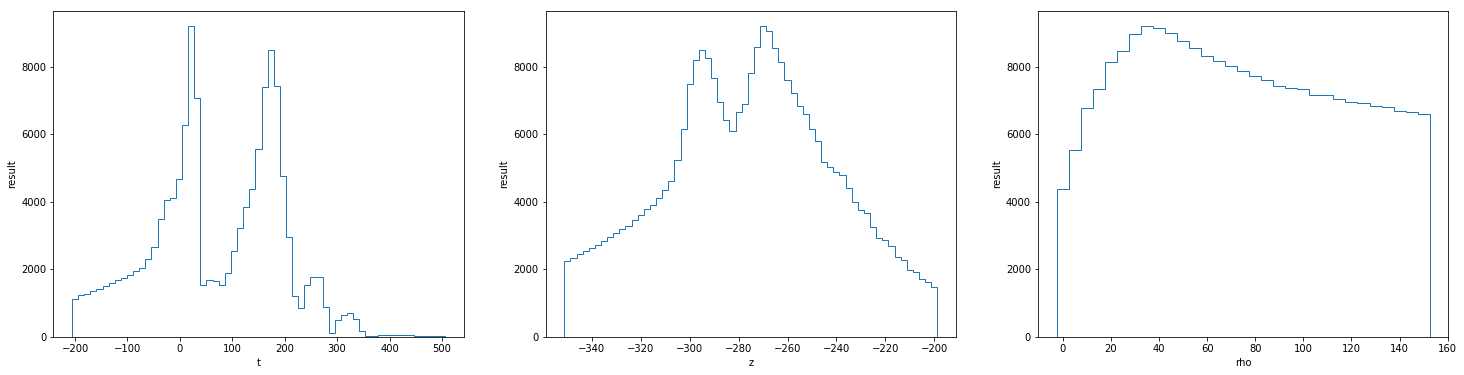

In [2099]:
fig, ax = plt.subplots(1,3,figsize=(25,6))

f(f(out, axis='rho'), axis='z').plot(ax=ax[0])
f(f(out, axis='rho'), axis='t').plot(ax=ax[1])
f(f(out, axis='t'), axis='z').plot(ax=ax[2])